In [ ]:
# %matplotlib qt5
%matplotlib inline
import numpy as np
from numpy import linalg as la
import matplotlib.pylab as plt
from scipy.optimize import fsolve
import math
import statsmodels.api as sm
from scipy.stats import norm
import seaborn as sns
from scipy import stats
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from Meanfield_Dyn_util import *


#### helper functions

In [ ]:
### dynamics
def iidGaussian(stats,shapem):
	mu,sig = stats[0],stats[1]
	nx,ny = shapem[0],shapem[1]
	return np.random.normal(mu,sig,(nx,ny))

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`
    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def list_to_dict(lst, string):
    """
    Transform a list of variables into a dictionary.
    Parameters
    ----------
    lst : list
        list with all variables.
    string : str
        string containing the names, separated by commas.
    Returns
    -------
    d : dict
        dictionary with items in which the keys and the values are specified
        in string and lst values respectively.
    """
    string = string[0]
    string = string.replace(']', '')
    string = string.replace('[', '')
    string = string.replace('\\', '')
    string = string.replace(' ', '')
    string = string.replace('\t', '')
    string = string.replace('\n', '')
    string = string.split(',')
    d = {s: v for s, v in zip(string, lst)}
    return d
def equations(x,data):
    '''
    Function: compute the largest real eigenvalue outlier of the matrix with chain motifs
    eqleft = (outlier**2+gaverage**2*tau)*(outlier**2-gaverage**2*tau*(N-1))
    eqright = outlier*eigvAm[0]*(outlier**2-gaverage**2*tau*(N-1))+gaverage**2*tau*eigvAm[0]*N
    f(outlier) = eqleft - eqright = 0
    params:
    data = [g, tau_chn, lambda_0, N]
    '''
    outlier = x
    gaverage,tau,eigvAm,N = data[0],data[1],data[2],data[3]
    eqleft = (outlier**2+gaverage**2*tau)*(outlier**2-gaverage**2*tau*(N-1))
    eqright = outlier*eigvAm*(outlier**2-gaverage**2*tau*(N-1))+gaverage**2*tau*eigvAm*outlier*N
    # eqright = outlier*eigvAm*(outlier**2+gaverage**2*tau)
    
    return (eqleft-eqright)
#### compute corresponding parameters and variables in the equivalent sparse networks
### Epopulation
def compute_AdjacencyParams(x,JE,JI,sigmae,sigmai,Nparams):
    ce,ci = x[0],x[1]
    NE,NI = Nparams[0],Nparams[1]
    N = NE+NI
    J = JE/NE/ce 
    Jg = JI/NI/ci
    
    sigmae2 = J**2*ce*(1-ce)*N 
    sigmai2 = Jg**2*ci*(1-ci)*N 
    
    resultse = sigmae**2-sigmae2
    resultsi = sigmai**2-sigmai2
    return np.array([resultse,resultsi])

def cal_eigv_radius_intersection(x,J,g,ce,ci,N,eigvchn_series,gaverage):
    tau = x[0]
    je, ji = J, g*J
    hat_sigmae, hat_sigmai = np.sqrt(ce*(1-ce)),np.sqrt(ci*(1-ci))
    sigmae, sigmai = np.sqrt(je**2*ce*(1-ce)*N), np.sqrt(ji**2*ci*(1-ci)*N) 
    ### generate tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec
    ### radius 
    tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec = np.zeros(2),np.zeros((2,2)),np.zeros((2,2)),np.zeros((2,2))
    ### YS: alltaus do not have E-I polarity
    tau_div_vec = np.array([tau,tau])
    tau_con_vec = np.array([[tau,tau],[tau,tau]])
    tau_rec_vec = np.array([[2*tau,-2*tau],[-2*tau,2*tau]])
    # tau_rec_vec = np.array([[2*tau,2*tau],[2*tau,2*tau]])
    tau_chn_vec = np.array([[tau,-tau],[-tau,tau]])
    # gamma = 1.0 ## NI/NE
    sigma = np.sqrt(sigmae**2/(1+gamma)+sigmai**2*gamma/(1+gamma))
    ### compute the radius 
    # compute a single number for multiple populations
    tau_div_num = hat_sigmae**2*tau_div_vec[0]+gamma*g**2*hat_sigmai**2*tau_div_vec[1]
    tau_div_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_div = tau_div_num/tau_div_den

    tau_con_num = hat_sigmae**2*tau_con_vec[0,0]+gamma*g**2*hat_sigmai**2*tau_con_vec[1,1]
    tau_con_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_con  = tau_con_num/tau_con_den

    tau_rec_num = hat_sigmae**2*tau_rec_vec[0,0] - (1+gamma)*g*hat_sigmae*hat_sigmai*tau_rec_vec[0,1]+gamma*g**2*hat_sigmai**2*tau_rec_vec[1,1]
    tau_rec_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_rec = tau_rec_num/tau_rec_den/2.0 

    tau_chn_num = hat_sigmae**2*tau_chn_vec[0,0] - 0.5*(1+gamma)*g*hat_sigmae*hat_sigmai*(tau_chn_vec[0,1]+tau_chn_vec[1,0])+gamma*g**2*hat_sigmai**2*tau_chn_vec[1,1]
    tau_chn_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_chn = tau_chn_num/tau_chn_den/2.0

    radius_theo = (1.0-tau_con-tau_div+tau_rec-2*tau_chn)/np.sqrt(1-tau_con-tau_div)*sigma

            
    ### then the theoretical solutions for the eigenvalue outliers
    ### theoretical solutions
    x0 = np.mean(eigvchn_series[:,1,:2].real,axis=0)
    for ir in range(2):
        t1 = fsolve(equations,x0[ir].real,args=[gaverage,tau,(JE-JI),N])
        eigvchn_theo = t1

    return eigvchn_theo-radius_theo

#### Network with Gaussian-distributed synaptic weights (multiple tau_chn, Fig2)

In [ ]:
nn = [50,100,150,250,600,500,800]#1600]
NE, NI = nn[-1], nn[-1] 
gamma = 1/4
NI = int(NE*gamma)
N = NE+NI
JE, JI  = 0.65,1.65
Nparams = np.array([NE,NI])
### mean connectivity
nvec, mvec = np.zeros((N,1)), np.ones((N,1))
nvec[:NE,0], nvec[NE:,0] = N*JE/NE, -N*JI/NI
Jbar = mvec@nvec.T/N 

tt = np.linspace(0,100,1000)
# g_max,tau_max = 0.1,0.1# Fig. 5, 6
g_max,tau_max = 0.2,0.1# Fig. 2
ntau,trials= 11,30+6
tau_series = np.linspace(0,tau_max,ntau)#np.linspace(0,0.2,ntau)
# recordings
eigvchn_series, eigrvec_series, eiglvec_series = np.zeros((trials,ntau,N),dtype=complex), np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
eiglvec0_series, norml0_series = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau+1,N)) 
htau = tau_series[1]-tau_series[0]
### also record the reconstructed eigenvectors
eigrvec_series_rec, eiglvec_series_rec = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
### mean connectivity
nvec, mvec = np.zeros((N,1)), np.ones((N,1))
nvec[:NE,0], nvec[NE:,0] = N*JE/NE, -N*JI/NI
Jbar = mvec@nvec.T/N 
### mean left and right eigenvectors
leigvec0, reigvec0 = np.zeros((N,N)), np.zeros((N,N))
norm_left = np.zeros(2)
leigvec0[:,0], reigvec0[:,0] = nvec[:,0]/(JE-JI)/np.sqrt(N), mvec[:,0]/np.sqrt(N)
norm_left[0]  = la.norm(leigvec0[:,0])
leigvec0[:,0] = leigvec0[:,0]/norm_left[0]
norml0_series[:,0,0] = np.sum(leigvec0[:,0]*reigvec0[:,0])

In [ ]:
'''### if you want to re-run the simulations for connectivity reconstruction, set flag to be True'''
rerun_conn = True  
eiglvec0norm_series= np.zeros((trials,ntau,N,2))
leig0mean_series = np.zeros((trials,ntau,N,2))
leig0pre_series = np.zeros((trials,ntau,N,2))
### simulation using the low-rank framework
gaverage = g_max
switch = 1
## numerical 
intg_std_series   = np.zeros((trials,ntau,2,2))### rank, population
intg_std_num_series = np.zeros((trials,ntau,2,2))### rank, population

if rerun_conn:
    for ktrial in range(trials):
        #### print the process   
        print('~~~~~~~~~~~trial:',ktrial,'~~~~~~~~~~~~~~~')
        xr      = iidGaussian([0,gaverage/np.sqrt(N)],[N,N])
        chneta  = iidGaussian([0,gaverage/np.sqrt(N)],[N,6])
        xrec    = iidGaussian([0,gaverage/np.sqrt(N)],[N,N])
        ### zscore iid recurrent component
        xr   = stats.zscore(xr.flatten())
        xr   = xr*gaverage/np.sqrt(N)
        xr   = np.reshape(xr,(N,N))
        ### zscore reciprocal component
        xrec = stats.zscore(xrec.flatten())
        xrec = xrec*gaverage/np.sqrt(N)
        xrec = np.reshape(xrec,(N,N))
        ### zscore chain component
        chneta[:,0]  = stats.zscore(chneta[:,0])
        chneta[:,0] *=(gaverage/np.sqrt(N))
        ### ---------------------
        z_pre = np.zeros((N,N))
        for it, tau in enumerate(tau_series):
            a    = np.sqrt(tau)
            zrow = a*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
            zcol = a*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
            gammarec = a*xrec-a*xrec.copy().T
            # zr   = zrow.copy()+zcol.copy()+np.sqrt(1-4*tau)*xr+gammarec ### reciprocal + chain
            zr   = zrow.copy()+zcol.copy()+np.sqrt(1-2*tau)*xr ### ignore reciprocal
            # zr = xrec*np.sqrt(tau/2)+xrec.copy().T*np.sqrt(tau/2)+np.sqrt(1-tau)*xr ### reciprocal        
            ha    = np.sqrt(htau)
            hzrow = ha*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
            hzcol = ha*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
            hgammarec = ha*xrec-ha*xrec.copy().T
            hzr   = hzrow.copy()+hzcol.copy()+np.sqrt(1-4*htau)*xr+hgammarec
            DELTA_Z = zr-z_pre
            hzr   = DELTA_Z.copy()

            ### generate J connectivity matrix
            Jchn = Jbar.copy()+zr.copy()     
            eigvchn, eigrvec = la.eig(Jchn)
            eigvchn_,eiglvec = la.eig(Jchn.copy().T)
            assert(np.sum(np.abs(eigvchn[0]-eigvchn_[0]))<1e-9)## check the consistency of left and right eigenvectors
            ### normalization
            reig  = np.squeeze(eigrvec[:,:].copy())
            leig0 = np.squeeze(eiglvec[:,:].copy()) 
            normval = np.sum(reig.copy()*leig0.copy(),axis=0)
            norml0_series[ktrial,it+1,:] = normval.copy() ### normalization factor shift right 1byte
            normval = np.repeat(np.reshape(normval,(1,N)),N,axis=0)
            leig = leig0.copy()/normval.copy()### left eigenvector normalization
            
            if np.mean(reig[:NE,0])<0:
                reig[:,0]*=-1
                leig[:,0]*=-1
                leig0[:,0]*=-1
            if np.mean(reig[:NE,1])<0: ### the second rank-1 component is negative
                reig[:,1]*=-1
                leig[:,1]*=-1
                leig0[:,1]*=-1
            ### numerical std 
            intg_std_num_series[ktrial,it,0,0] = np.std(reig[:NE,0])
            intg_std_num_series[ktrial,it,0,1] = np.std(reig[NE:,0])
            intg_std_num_series[ktrial,it,1,0] = np.std(reig[:NE,1])
            intg_std_num_series[ktrial,it,1,1] = np.std(reig[NE:,1])
            
            eigvchn_series[ktrial,it,:]    = eigvchn.copy()#eigvw_norm.copy()#
            eigrvec_series[ktrial,it,:,:]  = reig[:,:2].copy()#eigvecw_norm.copy()#
            eiglvec_series[ktrial,it,:,:]  = leig[:,:2].copy()#eigvect_norm.copy()#
            eiglvec0_series[ktrial,it,:,:] = leig0[:,:2].copy()#eigvect_norm.copy()#
            for iii in range(2):
                eiglvec0norm_series[ktrial,it,:,iii] = leig0[:,iii].copy()/normval[iii,iii]

            z_pre = zr.copy() #### this is important!!!!!


In [ ]:
### compute the theoretical eigenvalue outliers and the spectral radius
### recording 
gaverage     = g_max
eigvchn_theo = np.zeros((ntau,2))
radius_theo_map  = np.zeros(ntau)
        
for it, tau in enumerate(tau_series):
    ### solve the equations
    sigmae, sigmai = gaverage, gaverage
    
    x0 = np.array([0.01,0.01])
    # x0 = np.array([0.1,0.1])
    sol = fsolve(compute_AdjacencyParams,x0,args=(JE,JI,sigmae,sigmai,Nparams))
    ce,ci = sol[0],sol[1]
    J = JE/NE/ce
    g = JI/NI/ci/J
    print('ce,ci:',ce,ci)
    print('J,g:',J,g)
    ### generate the corresponding sparse matrix
    ### mean connectivity 
    je, ji = J, g*J
    hat_sigmae, hat_sigmai = np.sqrt(ce*(1-ce)),np.sqrt(ci*(1-ci))
    sigmae, sigmai = np.sqrt(je**2*ce*(1-ce)*N), np.sqrt(ji**2*ci*(1-ci)*N) 
    ### generate tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec
    tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec = np.zeros(2),np.zeros((2,2)),np.zeros((2,2)),np.zeros((2,2))
    ### YS: alltaus do not have E-I polarity
    tau_div_vec = np.array([tau,tau])
    tau_con_vec = np.array([[tau,tau],[tau,tau]])
    tau_rec_vec = np.array([[2*tau,-2*tau],[-2*tau,2*tau]])
    # tau_rec_vec = np.array([[2*tau,2*tau],[2*tau,2*tau]])
    tau_chn_vec = np.array([[tau,-tau],[-tau,tau]])
    # gamma = 1.0 ## NI/NE
    sigma = np.sqrt(sigmae**2/(1+gamma)+sigmai**2*gamma/(1+gamma))
    ### compute the radius 
    # compute a single number for multiple populations
    tau_div_num = hat_sigmae**2*tau_div_vec[0]+gamma*g**2*hat_sigmai**2*tau_div_vec[1]
    tau_div_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_div = tau_div_num/tau_div_den

    tau_con_num = hat_sigmae**2*tau_con_vec[0,0]+gamma*g**2*hat_sigmai**2*tau_con_vec[1,1]
    tau_con_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_con  = tau_con_num/tau_con_den

    tau_rec_num = hat_sigmae**2*tau_rec_vec[0,0] - (1+gamma)*g*hat_sigmae*hat_sigmai*tau_rec_vec[0,1]+gamma*g**2*hat_sigmai**2*tau_rec_vec[1,1]
    tau_rec_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_rec = tau_rec_num/tau_rec_den/2.0 

    tau_chn_num = hat_sigmae**2*tau_chn_vec[0,0] - 0.5*(1+gamma)*g*hat_sigmae*hat_sigmai*(tau_chn_vec[0,1]+tau_chn_vec[1,0])+gamma*g**2*hat_sigmai**2*tau_chn_vec[1,1]
    tau_chn_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_chn = tau_chn_num/tau_chn_den/2.0

    radius_theo = (1.0-tau_con-tau_div+tau_rec-2*tau_chn)/np.sqrt(1-tau_con-tau_div)*sigma
    
    radius_theo_map[it] = radius_theo
    print(radius_theo,gamma,hat_sigmae**2)
            
    ### then the theoretical solutions for the eigenvalue outliers
    ### theoretical solutions
    x0 = np.mean(eigvchn_series[:,it,:2].real,axis=0)
    N = int(NE+NI)
    for ir in range(2):
        t1 = fsolve(equations,x0[ir].real,args=[gaverage,tau,(JE-JI),N])
        eigvchn_theo[it,ir] = t1

In [66]:
'''save data'''
# params = {'gaverage':gaverage,
#           'gamma':gamma,
#           'NE':NE,
#           'NI':NI,
#           'JE':JE,
#           'JI':JI,
#           'tau_series':tau_series,
#           }
# lst = [eigvchn_series, eigrvec_series, eiglvec_series,
#        eigrvec_series_rec, eiglvec_series_rec,
#         eiglvec0_series, norml0_series, params,
#         intg_std_series,intg_std_num_series]
# stg = ["eigvchn_series, eigrvec_series, eiglvec_series,"
#        "eigrvec_series_rec, eiglvec_series_rec,"
#         "eiglvec0_series, norml0_series, params,"
#         "intg_std_series,intg_std_num_series"]
# data = list_to_dict(lst=lst, string=stg)
# data_name = "---save data path---"
# np.savez(data_name,**data)
''' reload stored data '''
# data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/19Mar_eigenvectors_corrected/Gaussian_data/ConnStats_Gauss_19MarPRX_normlr_N1000.npz"# Used for eigenvector corresponding to the dynamics
# data = np.load(data_name,allow_pickle=True)
# ### also loading other variables 
# eigvchn_series = data['eigvchn_series']
# # eigrvec_series = data['eigrvec_series']
# # eiglvec_series = data['eiglvec_series']
# params = data['params']
# # firing_rateeq = data['firing_rateeq']
# params


' reload stored data '

In [28]:
### compute the numerical radius of eigenvalue bulk
radius_num_map = np.zeros((trials,ntau))
for ktrial in range(trials):
    for it in range(ntau): 
        eigvchn = eigvchn_series[ktrial,it,:].copy()

        eigvchn_real = np.real(eigvchn)
        eigvchn_real = np.sort(eigvchn_real)
        eigvchn_real = eigvchn_real[::-1]

        radius = (eigvchn_real[2])
        radius_num_map[ktrial,it] = radius


Plot the Eigenvalues outliers and Bulk

In [29]:
### sorting the 3 maximum eigvchn_series[:,-1,0].real and 3 minimum
eigvchn_real = eigvchn_series[:,-1,0].real.copy()
### sorting eigvchn_real 
idx = np.argsort(eigvchn_real)
idx_eff = idx[3:-3]
print('effective trials:',idx_eff,len(idx_eff))

effective trials: [34 27 29 21 18 11 30 22  3 32 26 17 14  0 23 33 19  9 25 16 31  1 28 24
 12 13  4  7 35 10] 30


In [ ]:
# np.where(radius_theo_map<eigvchn_theo[:,-1])[0][0]
''' Compute the intersection of eigvchn_theo and radius_theo_map, using their equations  '''
gaverage = g_max#0.1#g_max      
### solve the equations
sigmae, sigmai = gaverage, gaverage

x0 = np.array([0.01,0.01])
# x0 = np.array([0.1,0.1])
sol = fsolve(compute_AdjacencyParams,x0,args=(JE,JI,sigmae,sigmai,Nparams))
ce,ci = sol[0],sol[1]
J = JE/NE/ce
g = JI/NI/ci/J
print('ce,ci:',ce,ci)
print('J,g:',J,g)
### solve the equations
sigmae, sigmai = gaverage, gaverage
xinit = np.array([0.01])
xintersect = fsolve(cal_eigv_radius_intersection,xinit,args=(J,g,ce,ci,N,eigvchn_series.copy(),gaverage))
print(xintersect)
### compute the eigvchn_theo[:,1] and radius_theo_map intersection
idx = np.argmin(np.abs(tau_series-xintersect))
intersect = np.where(eigvchn_theo[:,1]<=radius_theo_map)[0]
print(intersect[-1])
print('radius',radius_theo_map)
print('eigvth:',eigvchn_theo[:,1])

Fig. 2a

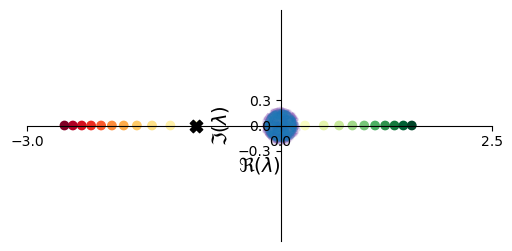

In [25]:
''' Fig 2a '''
fig,ax=plt.subplots(figsize=(6,3))
### plot the mean of the eigenvalues, how it changes with tau_series
### colormap gradiently changes with the tau_series
cm = plt.cm.YlOrRd
### the mean of the first eigenvalue
mean_eigvchn = np.mean(eigvchn_series[idx_eff,:,0].real,axis=0)
# sc=ax.scatter(mean_eigvchn,-0.1*np.ones(ntau),c=tau_series,cmap=cm)
sc=ax.scatter(mean_eigvchn,np.zeros(ntau),c=tau_series+0.1,cmap=cm)
### the mean of the second eigenvalue 
cm = plt.cm.YlGn
mean_eigvchn = np.mean(eigvchn_series[idx_eff,:,1].real,axis=0)
sc=ax.scatter(mean_eigvchn,np.zeros(ntau),c=tau_series+0.1,cmap=cm)

ax.set_xlabel(r'$\Re(\lambda)$',fontsize=14)
### set double ylabels
ax.set_ylabel(r'$\Im(\lambda)$',fontsize=14)
ax2 = ax.twinx() 
 
color = 'tab:gray'
ax2.tick_params(axis ='y', labelcolor = color) 
ax2.set_yticks([])
ax2.spines['bottom'].set_color('none')
### set other x-axis invisible
ax2.spines['top'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.spines['left'].set_color('none')
### refine the plot 
# ax.set_xlim([-3,2])
# ax.set_ylim([-0.3,0.3])
ax.set_xlim([-1.8,0.8])
ax.set_ylim([-0.3,0.3])

ax.set_aspect('equal')
ax.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data',0))
## set the x and y ticks
ax.set_xticks([-1.5,0,0.5])
ax.set_yticks([-0.3,0,0.3])

ax.set_xticks([-3,0,2.5])
ax.set_yticks([-0.3,0,0.3])

### plot a circle with the radius of the last radius_num_map
ax.add_patch(plt.Circle((0,0),radius_theo_map[-1],color='tab:blue',fill=False,linewidth=1.5,alpha=1))
### plot a circle with the radius of the first radius_num_map
ax.add_patch(plt.Circle((0,0),radius_theo_map[0],color='tab:purple',fill=False,linewidth=1.5,alpha=0.5,linestyle='--'))

ktrial_index = 16
### scatter plot the eigenvalue bulk of this trial
### randomly select 500 points
idx_random = np.random.choice(np.arange(2,N),size=500,replace=False)
ax.scatter(eigvchn_series[ktrial_index,0,idx_random].real,eigvchn_series[ktrial_index,0,idx_random].imag,color='tab:purple', s=5,alpha=0.15)
ax.scatter(eigvchn_series[ktrial_index,-1,idx_random].real,eigvchn_series[ktrial_index,-1,idx_random].imag,color='tab:blue', s=5,alpha=0.2)
### also plot the original eigenvalue outlier: JE-JI, using red color and X marker
ax.scatter(JE-JI,0,color='black',marker='X',s=80,alpha=1)
plt.show()


Fig. 2b

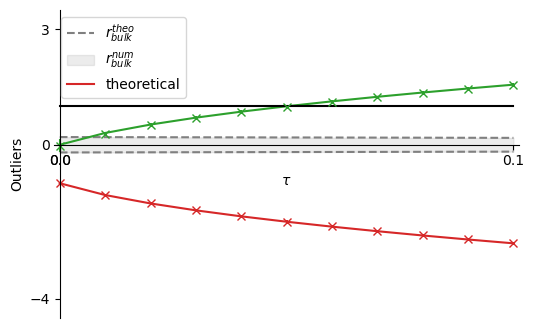

In [32]:
'''Fig 2b'''
fig,ax = plt.subplots(figsize=(6,4))
### label is r_{bulk}^{num}
ax.plot(tau_series,radius_theo_map,'gray',linestyle='--',label=r'$r_{bulk}^{theo}$')
ax.plot(tau_series,-radius_theo_map,'gray',linestyle='--')
# ax.plot(tau_series,np.mean(radius_num_map,axis=0),'k',label=r'$r_{bulk}^{num}$')
ax.fill_between(tau_series,np.mean(radius_num_map,axis=0),-np.mean(radius_num_map,axis=0),color='gray',alpha=0.15,label=r'$r_{bulk}^{num}$')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Radius')
ax.legend()
ax.plot(tau_series,eigvchn_theo[:,0],'tab:red',label='theoretical')
ax.plot(tau_series,eigvchn_theo[:,1],'tab:green')

ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,0].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,0].real,axis=0),fmt='x',color='tab:red', ecolor='tab:red',alpha=1,ls='',elinewidth=1.5)
ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,1].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,1].real,axis=0),fmt='x',color='tab:green',ecolor='tab:green',alpha=1,ls='',elinewidth=1.5)
    
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Outliers')
### set x and y lims as well as ticks
dtau = tau_series[1]-tau_series[0] 
ax.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
ax.set_xticks([0,tau_series[-1]//2,tau_series[-1]])
ax.set_ylim([-2.5,1.5])
ax.set_yticks([-2,0,1])
ax.set_ylim([-4.5,3.5])
ax.set_yticks([-4,0,3])
ax.legend()
### move the x and y axis to the center
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.plot(tau_series,np.ones(len(tau_series)),'k',linewidth=1.5)    
plt.show()

Single realization

In [34]:
''' Run a single network with a specific chain strength (single realization) '''
### if you want to re-run the simulations for connectivity, set flag to be True
rerun_conn = True  
eiglvec0norm_series= np.zeros((trials,ntau,N,2))
leig0mean_series = np.zeros((trials,ntau,N,2))
leig0pre_series = np.zeros((trials,ntau,N,2))
### simulation using the low-rank framework
gaverage = g_max
switch = 1
## numerical 
intg_std_series   = np.zeros((trials,ntau,2,2))### rank, population
intg_std_num_series = np.zeros((trials,ntau,2,2))### rank, population

if rerun_conn:
    for ktrial in range(1):
        #### print the process   
        print('~~~~~~~~~~~trial:',ktrial,'~~~~~~~~~~~~~~~')
        xr      = iidGaussian([0,gaverage/np.sqrt(N)],[N,N])
        chneta  = iidGaussian([0,gaverage/np.sqrt(N)],[N,6])
        xrec    = iidGaussian([0,gaverage/np.sqrt(N)],[N,N])
        ### zscore iid recurrent component
        xr   = stats.zscore(xr.flatten())
        xr   = xr*gaverage/np.sqrt(N)
        xr   = np.reshape(xr,(N,N))
        ### zscore reciprocal component
        xrec = stats.zscore(xrec.flatten())
        xrec = xrec*gaverage/np.sqrt(N)
        xrec = np.reshape(xrec,(N,N))
        ### zscore chain component
        chneta[:,0]  = stats.zscore(chneta[:,0])
        chneta[:,0] *=(gaverage/np.sqrt(N))
        ### ---------------------
        z_pre = np.zeros((N,N))
        it, tau = 0, tau_series[-1]
        a    = np.sqrt(tau)
        zrow = a*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
        zcol = a*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
        gammarec = a*xrec-a*xrec.copy().T
        # zr   = zrow.copy()+zcol.copy()+np.sqrt(1-4*tau)*xr+gammarec ### reciprocal + chain
        zr   = zrow.copy()+zcol.copy()+np.sqrt(1-2*tau)*xr ### ignore reciprocal
        # zr = xrec*np.sqrt(tau/2)+xrec.copy().T*np.sqrt(tau/2)+np.sqrt(1-tau)*xr ### reciprocal        
        ha    = np.sqrt(htau)
        hzrow = ha*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
        hzcol = ha*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
        hgammarec = ha*xrec-ha*xrec.copy().T
        hzr   = hzrow.copy()+hzcol.copy()+np.sqrt(1-4*htau)*xr+hgammarec
        DELTA_Z = zr-z_pre
        hzr   = DELTA_Z.copy()

        ### generate J connectivity matrix
        Jchn = Jbar.copy()+zr.copy()     
        eigvchn, eigrvec = la.eig(Jchn)
        eigvchn_,eiglvec = la.eig(Jchn.copy().T)
        assert(np.sum(np.abs(eigvchn[0]-eigvchn_[0]))<1e-9)## check the consistency of left and right eigenvectors
        ### normalization
        reig  = np.squeeze(eigrvec[:,:].copy())
        leig0 = np.squeeze(eiglvec[:,:].copy()) 
        normval = np.sum(reig.copy()*leig0.copy(),axis=0)
        norml0_series[ktrial,it+1,:] = normval.copy() ### normalization factor shift right 1byte
        normval = np.repeat(np.reshape(normval,(1,N)),N,axis=0)
        leig = leig0.copy()/normval.copy()### left eigenvector normalization
        
        if np.mean(reig[:NE,0])<0:
            reig[:,0]*=-1
            leig[:,0]*=-1
            leig0[:,0]*=-1
        if np.mean(reig[:NE,1])<0: ### the second rank-1 component is negative
            reig[:,1]*=-1
            leig[:,1]*=-1
            leig0[:,1]*=-1
        ### numerical std 
        intg_std_num_series[ktrial,it,0,0] = np.std(reig[:NE,0])
        intg_std_num_series[ktrial,it,0,1] = np.std(reig[NE:,0])
        intg_std_num_series[ktrial,it,1,0] = np.std(reig[:NE,1])
        intg_std_num_series[ktrial,it,1,1] = np.std(reig[NE:,1])
        
        eigvchn_series[ktrial,it,:]    = eigvchn.copy()#eigvw_norm.copy()#
        eigrvec_series[ktrial,it,:,:]  = reig[:,:2].copy()#eigvecw_norm.copy()#
        eiglvec_series[ktrial,it,:,:]  = leig[:,:2].copy()#eigvect_norm.copy()#
        eiglvec0_series[ktrial,it,:,:] = leig0[:,:2].copy()#eigvect_norm.copy()#
        for iii in range(2):
            eiglvec0norm_series[ktrial,it,:,iii] = leig0[:,iii].copy()/normval[iii,iii]

        z_pre = zr.copy() #### this is important!!!!!


~~~~~~~~~~~trial: 0 ~~~~~~~~~~~~~~~


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12216\3627278194.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  norml0_series[ktrial,it+1,:] = normval.copy() ### normalization factor shift right 1byte
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12216\3627278194.py:78: ComplexWarning: Casting complex values to real discards the imaginary part
  eigrvec_series[ktrial,it,:,:]  = reig[:,:2].copy()#eigvecw_norm.copy()#
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12216\3627278194.py:79: ComplexWarning: Casting complex values to real discards the imaginary part
  eiglvec_series[ktrial,it,:,:]  = leig[:,:2].copy()#eigvect_norm.copy()#
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12216\3627278194.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
  eiglvec0_series[ktrial,it,:,:] = leig0[:,:2].copy()#eigvect_norm.copy()#
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12216\3627278194.py:82: Comple

Fig. 2a (single realization)

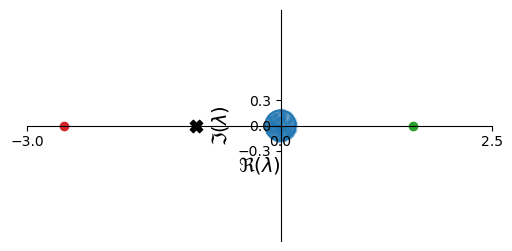

In [39]:
''' Fig 2a (single) '''
fig,ax=plt.subplots(figsize=(6,3))
### plot the mean of the eigenvalues, how it changes with tau_series
### colormap gradiently changes with the tau_series
cm = plt.cm.YlOrRd
### the mean of the first eigenvalue
mean_eigvchn = eigvchn_series[0,0,0].real
# sc=ax.scatter(mean_eigvchn,-0.1*np.ones(ntau),c=tau_series,cmap=cm)
sc=ax.scatter(mean_eigvchn,0,c='tab:red')
### the mean of the second eigenvalue 
cm = plt.cm.YlGn
mean_eigvchn = eigvchn_series[0,0,1].real
sc=ax.scatter(mean_eigvchn,0,c='tab:green')

ax.set_xlabel(r'$\Re(\lambda)$',fontsize=14)
### set double ylabels
ax.set_ylabel(r'$\Im(\lambda)$',fontsize=14)
ax2 = ax.twinx() 
 
color = 'tab:gray'
ax2.tick_params(axis ='y', labelcolor = color) 
ax2.set_yticks([])
ax2.spines['bottom'].set_color('none')
### set other x-axis invisible
ax2.spines['top'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.spines['left'].set_color('none')
### refine the plot 
# ax.set_xlim([-3,2])
# ax.set_ylim([-0.3,0.3])
ax.set_xlim([-1.8,0.8])
ax.set_ylim([-0.3,0.3])

ax.set_aspect('equal')
ax.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data',0))
## set the x and y ticks
ax.set_xticks([-1.5,0,0.5])
ax.set_yticks([-0.3,0,0.3])

ax.set_xticks([-3,0,2.5])
ax.set_yticks([-0.3,0,0.3])

### plot a circle with the radius of the last radius_num_map
ax.add_patch(plt.Circle((0,0),radius_theo_map[-1],color='tab:blue',fill=False,linewidth=1.5,alpha=1))

ktrial_index = 0
### scatter plot the eigenvalue bulk of this trial
### randomly select 500 points
idx_random = np.random.choice(np.arange(2,N),size=500,replace=False)
ax.scatter(eigvchn_series[ktrial_index,0,idx_random].real,eigvchn_series[ktrial_index,0,idx_random].imag,color='tab:blue', s=5,alpha=0.15)
### also plot the original eigenvalue outlier: JE-JI, using red color and X marker
ax.scatter(JE-JI,0,color='black',marker='X',s=80,alpha=1)
plt.show()


In [ ]:
# params = {'gaverage':gaverage,
#           'gamma':gamma,
#           'JE':JE,
#           'JI':JI,
#           'NE':NE,
#           'NI':NI,
#           'tau_series':tau_series,
#           }
# lst = [eigvchn_series, eigrvec_series, eiglvec_series,
#        eigrvec_series_rec, eiglvec_series_rec,
#         eiglvec0_series, norml0_series, params,
#         intg_std_series,intg_std_num_series,
#         leig0mean_series,radius_theo_map,eigvchn_theo,radius_num_map]
# stg = ["eigvchn_series, eigrvec_series, eiglvec_series,"
#        "eigrvec_series_rec, eiglvec_series_rec,"
#         "eiglvec0_series, norml0_series, params,"
#         "intg_std_series,intg_std_num_series,"
#         "leig0mean_series,radius_theo_map,eigvchn_theo,radius_num_map"]
# data = list_to_dict(lst=lst, string=stg)
# data_name = "---save data path---"
# # np.savez(data_name, **data)

#### low-rank connectivity and network dynamics (Figs5 and 6)

In [40]:
import scipy
from functools import partial
def odeIntegral(x,t,J,I=0):
    x = np.squeeze(x)
    x = np.reshape(x,(len(x),1))
    # dxdt = -x+J@np.tanh(x)#+I[0]
    dxdt = -x+J@(x)+I[0]
    return np.squeeze(dxdt)
def odesimulation(t,xinit,Jpt,I):
	return scipy.integrate.odeint(partial(odeIntegral,J=Jpt,I=I),xinit,t)

We use linear response theory here, and focus on the population-averaged responses, for a specific population $p$, the equilibrium firing rate is computed analytically

$$ \langle r\rangle_{i\in N_p}=I^{s,p}+\sum_{r=1}^{R}\frac{a_{m_r}^p}{1-\lambda_r}\sum_{q=E,I}N_qa_{n_r}^qI^{s,q}$$

In [41]:
nn = [50,100,150,250,750,500,800]
NE, NI = nn[-1], nn[-1] 
gamma = 1/4
NI = int(NE*gamma)
N = NE+NI
JE, JI =  0.65, 1.65#1.5, 2.0#1.5, 2.0
Nparams = np.array([NE,NI])
### mean connectivity
nvec, mvec = np.zeros((N,1)), np.ones((N,1))
nvec[:NE,0], nvec[NE:,0] = N*JE/NE, -N*JI/NI
Jbar = mvec@nvec.T/N 

tt  = np.linspace(0,100,1000)
g_max,tau_max = 0.10,.1
ntau = 6### even quit sparse taus can generate accurate predictions
ntau = 11## denser taus
tau_series = np.linspace(0,tau_max,ntau)#np.linspace(0,0.2,ntau)
trials = 30+6 #is the minimal number of iterations
# recordings
eigvchn_series, eigrvec_series, eiglvec_series = np.zeros((trials,ntau,N),dtype=complex), np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
eiglvec0_series, norml0_series = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau+1,N)) 
htau    = tau_series[1]-tau_series[0]

### also record the reconstructed eigenvectors
eigrvec_series_rec, eiglvec_series_rec = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))

### mean connectivity
nvec, mvec = np.zeros((N,1)), np.ones((N,1))
nvec[:NE,0], nvec[NE:,0] = N*JE/NE, -N*JI/NI
Jbar = mvec@nvec.T/N 
### mean left and right eigenvectors
leigvec0, reigvec0 = np.zeros((N,N)), np.zeros((N,N))
norm_left = np.zeros(2)
leigvec0[:,0], reigvec0[:,0] = nvec[:,0]/(JE-JI)/np.sqrt(N), mvec[:,0]/np.sqrt(N)
norm_left[0] = la.norm(leigvec0[:,0])
leigvec0[:,0] = leigvec0[:,0]/norm_left[0]
norml0_series[:,0,0] = np.sum(leigvec0[:,0]*reigvec0[:,0])
kk = np.sqrt(NE*JI**2+NI*JE**2)
reigvec0[:NE,1], reigvec0[NE:,1] = JI/kk,JE/kk 
leigvec0[:NE,1], leigvec0[NE:,1] = -kk/(JE-JI)/NE,kk/(JE-JI)/NI 
norm_left[1]  = la.norm(leigvec0[:,1])
leigvec0[:,1] = leigvec0[:,1]/norm_left[1]
norml0_series[:,0,1] = np.sum(leigvec0[:,1]*reigvec0[:,1])
outerproduct  = np.sum(leigvec0[:,0]*reigvec0[:,1])#*norm_left

Mean network's dynamics in response to uniform stimuli

In [42]:
#### constant and deterministic input signal
Inp   = np.squeeze(np.ones((N,1)))/np.sqrt(N) 
#### random and structural input signal 
### simulation using the mean network connectivity (inhibition-dominated)
Jpt   = Jbar.copy()
xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
tt    = np.linspace(0,100,1000)
xtemporal = odesimulation(tt, xinit, Jpt, Inp)
firing_rate0 = np.reshape(xtemporal[-1,:N],(N,1))

##### Eigenvector statistics correspond to eigenvalues in the bulk (Optional)

Numerically compute the statistics of the eigenvectors (including those corresponding to the eigenvalues within the bulk)

In [43]:
### if you want to re-run the simulation
### simulation using the low-rank framework
trials = 36
firing_rateeq = np.zeros((trials,ntau,N))
firing_rateeq_bulk = np.zeros((trials,ntau,N))
### recording dynamics
lowrank_eq, lowrank_eq_num = np.zeros((trials,ntau,2)), np.zeros((trials,ntau,N))
contributions_lr, contributions_lr_num = np.zeros((trials,ntau,2,2)), np.zeros((trials,ntau,2,2))### rank, population

gaverage = 0.1#g_max ### set the magnitude of the connectivity fluctuation
switch   = 1#0#

eigvchn_series_bulk, eigrvec_series_bulk, eiglvec_series_bulk = np.zeros((trials,ntau,N),dtype=complex), np.zeros((trials,ntau,N,N)), np.zeros((trials,ntau,N,N))
eiglvec0_series_bulk, norml0_series = np.zeros((trials,ntau,N,N)), np.zeros((trials,ntau+1,N)) 
### trials random networks and vectors 
xrs   = np.zeros((trials,N,N))
xrecs = np.zeros((trials,N,N))
chnetas = np.zeros((trials,N,6))

### generate the random connectivity components for each individual realizations
for ktrial in range(trials):
    xrs[ktrial,:,:]      = iidGaussian([0,gaverage/np.sqrt(N)],[N,N])
    chnetas[ktrial,:,:]  = iidGaussian([0,gaverage/np.sqrt(N)],[N,6])
    xrecs[ktrial,:,:]    = iidGaussian([0,gaverage/np.sqrt(N)],[N,N])
    ### zscore
    xrs_   = stats.zscore(xrs[ktrial,:,:].flatten())
    xrs_  = xrs_*gaverage/np.sqrt(N)
    xrs[ktrial,:,:]   = np.reshape(xrs[ktrial,:,:],(N,N))
    ### zscore
    xrecs_ = stats.zscore(xrecs[ktrial,:,:].flatten())
    xrecs_ = xrecs_*gaverage/np.sqrt(N)
    xrecs[ktrial,:,:] = np.reshape(xrecs_,(N,N))
    ### zscore
    chnetas[ktrial,:,0] = stats.zscore(chnetas[ktrial,:,0])
    chnetas[ktrial,:,0] *= (gaverage/np.sqrt(N))

### if you want to re-run the simulations for dynamics, set rerun_dyns to be True 
rerun_dyns = True   
z_pre = 0
if rerun_dyns:
    for it, tau in enumerate(tau_series):
        a    = np.sqrt(tau)
        #switch:### using numerical
        z_forder_square = np.zeros((N,N))
        z_sorder_square = np.zeros((N,N))
        z_forder_square_n = np.zeros((N,N))
        norm_lvec = np.zeros((trials,2))
        for ktrial in range(trials):
            xr      = xrs[ktrial,:,:]
            chneta  = chnetas[ktrial,:,:]
            xrec    = xrecs[ktrial,:,:]
            
            zrow = a*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
            zcol = a*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
            gammarec = a*xrec-a*xrec.copy().T
            # zr   = zrow.copy()+zcol.copy()+np.sqrt(1-4*tau)*xr+gammarec ## both reciprocal and chain 
            zr   = zrow.copy()+zcol.copy()+np.sqrt(1-2*tau)*xr  ## ignore reciprocal
            if it==0:
                zr_pre = np.zeros_like(zr)
            else:
                a_pre = np.sqrt(tau_series[it-1])
                zrow_pre = a_pre*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
                zcol_pre = a_pre*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
                gammarec_pre = a_pre*xrec-a_pre*xrec.copy().T
                zr_pre   = zrow_pre.copy()+zcol_pre.copy()+np.sqrt(1-2*tau_series[it-1])*xr
                
    
            ### generate J connectivity matrix
            Jchn = Jbar.copy()+zr.copy()
            ### full rank simulation
            xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
            xc_temporal = odesimulation(tt, xinit, Jchn, Inp)
            firing_rateeq[ktrial,it,:] = xc_temporal[-1,:].copy()
            
            eigvchn, eigrvec = la.eig(Jchn)
            eigvchn_,eiglvec = la.eig(Jchn.copy().T)
            assert(np.sum(np.abs(eigvchn[0]-eigvchn_[0]))<1e-9)## check the consistency of left and right eigenvectors
            ### normalization
            reig  = np.squeeze(eigrvec[:,:].copy())            
            ### inverse left eigenvector
            inveigrvec       = la.inv(eigrvec)
            leig = np.squeeze(inveigrvec[:,:].copy()) # inverse
            leig = leig.copy().T
            ### leig0 is normalized 
            norm_lvec[ktrial,:] = la.norm(leig[:,:2],axis=0)
            leig0 = leig/la.norm(leig,axis=0)
        

            if np.mean(reig[:NE,0])<0:
                reig[:,0]*=-1
                leig[:,0]*=-1
                leig0[:,0]*=-1
            if np.mean(reig[:NE,1])<0: ### the second rank-1 component is negative
                reig[:,1]*=-1
                leig[:,1]*=-1
                leig0[:,1]*=-1
                
            # ### bulk simulation
            # xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
            # ### generate a diagonal matrix with elements eigvchn[2:]
            # Lambda2_ = np.diag(eigvchn[:2].real)
            # bulk = Jchn - reig[:,:2].real@Lambda2_@(leig[:,:2].T).real
            # xc_temporal = odesimulation(tt, xinit, bulk, Inp)
            # firing_rateeq_bulk[ktrial,it,:] = xc_temporal[-1,:].copy()
            # print('bulk dyns:',np.mean(xc_temporal[-1,:NE]),np.mean(xc_temporal[-1,NE:]),Inp[-1])
                
       
            eigvchn_series_bulk[ktrial,it,:]    = eigvchn.copy()#eigvw_norm.copy()#
            eigrvec_series_bulk[ktrial,it,:,:]  = reig[:,:].copy()#eigvecw_norm.copy()#
            eiglvec_series_bulk[ktrial,it,:,:]  = leig[:,:].copy()#eigvect_norm.copy()#
            eiglvec0_series_bulk[ktrial,it,:,:] = leig0[:,:].copy()#eigvect_norm.copy()#

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12216\2484315721.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
  eigrvec_series_bulk[ktrial,it,:,:]  = reig[:,:].copy()#eigvecw_norm.copy()#
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12216\2484315721.py:110: ComplexWarning: Casting complex values to real discards the imaginary part
  eiglvec_series_bulk[ktrial,it,:,:]  = leig[:,:].copy()#eigvect_norm.copy()#
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12216\2484315721.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  eiglvec0_series_bulk[ktrial,it,:,:] = leig0[:,:].copy()#eigvect_norm.copy()#


In [ ]:
'''### compute the trial averaged mean value of elements on left/right eigenvectors (bulk) '''
# eigvchn_series = data['eigvchn_series']
# ntau = np.shape(eigvchn_series)[1]
# trials = np.shape(eigvchn_series)[0]
# NE, NI = params['NE'],params['NI']
### numerical
mean_reigvec_num_series_bulk = np.zeros((trials,ntau,N,2))
mean_leigvec_num_series_bulk = np.zeros((trials,ntau,N,2))
mean_leig0vec_num_series_bulk = np.zeros((trials,ntau,N,2))
thl = 10
ths = 0.5
                
### for the numerical 
for ktrial in range(trials):
    for it in range(ntau):
        for ir in range(N):
            mean_reigvec_num_series_bulk[ktrial,it,ir,0] = np.mean(eigrvec_series_bulk[ktrial,it,:NE,ir])
            mean_reigvec_num_series_bulk[ktrial,it,ir,1] = np.mean(eigrvec_series_bulk[ktrial,it,NE:,ir])
            mean_leigvec_num_series_bulk[ktrial,it,ir,0] = np.mean(eiglvec_series_bulk[ktrial,it,:NE,ir])*eigvchn_series_bulk[ktrial,it,ir]
            mean_leigvec_num_series_bulk[ktrial,it,ir,1] = np.mean(eiglvec_series_bulk[ktrial,it,NE:,ir])*eigvchn_series_bulk[ktrial,it,ir]
            mean_leig0vec_num_series_bulk[ktrial,it,ir,0] = np.mean(eiglvec0_series_bulk[ktrial,it,:NE,ir])
            mean_leig0vec_num_series_bulk[ktrial,it,ir,1] = np.mean(eiglvec0_series_bulk[ktrial,it,NE:,ir])


In [ ]:
# '''### plot the histogram of mean_reigvec_num_series_bulk '''
# fig,ax = plt.subplots(figsize=(6,3))
# binss = np.linspace(-0.01,0.01,60)
# # for ir in range(N):
# ax.hist(mean_reigvec_num_series_bulk[:,0,2:,0].flatten(),bins=binss,alpha=0.5,facecolor='tab:red',label='E',density=True)
# ax.hist(mean_reigvec_num_series_bulk[:,0,2:,1].flatten(),bins=binss,alpha=0.5,facecolor='tab:blue',label='I',density=True)
# ax.set_xticks([-0.01,0,0.01])

# fig,ax = plt.subplots(figsize=(6,3))
# binss = np.linspace(-.11,.11,60)
# # for ir in range(N):
# ax.hist(mean_leigvec_num_series_bulk[:,0,2:,0].flatten(),bins=binss,alpha=0.5,facecolor='tab:red',label='E',density=True)
# ax.hist(mean_leigvec_num_series_bulk[:,0,2:,1].flatten(),bins=binss,alpha=0.5,facecolor='tab:blue',label='I',density=True)

# # ax.hist(mean_leigvec_num_series_bulk[:,0,2:,0].flatten(),bins=60,alpha=0.5,facecolor='tab:red',label='E',density=True)
# # ax.hist(mean_leigvec_num_series_bulk[:,0,2:,1].flatten(),bins=60,alpha=0.5,facecolor='tab:blue',label='I',density=True)
# ax.set_xticks([-0.1,0,0.1])


# for it in range(ntau):
#     print('mean',np.mean(mean_reigvec_num_series_bulk[:,it,:,0].flatten()))
#     print('std',np.std(mean_reigvec_num_series_bulk[:,it,:,0].flatten()))

# mean_reigvec_num_series_bulk *= np.sqrt(N)
# mean_leigvec_num_series_bulk *= np.sqrt(N)
# mean_leig0vec_num_series_bulk *= np.sqrt(N)

# np.shape(mean_reigvec_num_series_bulk)


In [ ]:
### plot the mean of the left and right eigenvectors
dtau = tau_series[1]-tau_series[0]
tau_max = tau_series[-1]
### compute the mean and variance regarding different tau^c  
mean_bulk, std_bulk = np.zeros((ntau,2)), np.zeros((ntau,2))
mean_bulk_lr, std_bulk_lr = np.zeros((ntau,2,2)), np.zeros((ntau,2,2))
for it in range(ntau):
    mean_bulk[it,0],mean_bulk[it,1] = np.mean(mean_reigvec_num_series_bulk[:,it,2:,0].flatten()),np.mean(mean_reigvec_num_series_bulk[:,it,2:,1].flatten())
    std_bulk[it,0],std_bulk[it,1] = np.std(mean_reigvec_num_series_bulk[:,it,2:,0].flatten()),np.std(mean_reigvec_num_series_bulk[:,it,2:,1].flatten())
    
    ### first 
    mean_bulk_lr[it,0,0],mean_bulk_lr[it,0,1] = np.mean(mean_reigvec_num_series_bulk[:,it,0,0].flatten()),np.mean(mean_reigvec_num_series_bulk[:,it,0,1].flatten())
    std_bulk_lr[it,0,0],std_bulk_lr[it,0,1] = np.std(mean_reigvec_num_series_bulk[:,it,0,0].flatten()),np.std(mean_reigvec_num_series_bulk[:,it,0,1].flatten())
    ### second
    mean_bulk_lr[it,1,0],mean_bulk_lr[it,1,1] = np.mean(mean_reigvec_num_series_bulk[:,it,1,0].flatten()),np.mean(mean_reigvec_num_series_bulk[:,it,1,1].flatten())
    std_bulk_lr[it,1,0],std_bulk_lr[it,1,1] = np.std(mean_reigvec_num_series_bulk[:,it,1,0].flatten()),np.std(mean_reigvec_num_series_bulk[:,it,1,1].flatten())
    
    
fig,ax=plt.subplots(1,2,figsize=(8,3),sharex=True,sharey=True)
ax[0].fill_between(tau_series,mean_bulk[:,0]-std_bulk[:,0],mean_bulk[:,0]+std_bulk[:,0],facecolor='gray',alpha=1.0)

ax[1].fill_between(tau_series,mean_bulk[:,1]-std_bulk[:,1],mean_bulk[:,1]+std_bulk[:,1],facecolor='gray',alpha=1.0)

# ax[0].fill_between(tau_series,mean_bulk_lr[:,0,0]-std_bulk_lr[:,0,0],mean_bulk_lr[:,0,0]+std_bulk_lr[:,0,0],facecolor='gray',alpha=1.0)

# ax[1].fill_between(tau_series,mean_bulk_lr[:,0,1]-std_bulk_lr[:,0,1],mean_bulk_lr[:,0,1]+std_bulk_lr[:,0,1],facecolor='gray',alpha=1.0)

# ax[0].fill_between(tau_series,mean_bulk_lr[:,1,0]-std_bulk_lr[:,1,0],mean_bulk_lr[:,1,0]+std_bulk_lr[:,1,0],facecolor='gray',alpha=1.0)

# ax[1].fill_between(tau_series,mean_bulk_lr[:,1,1]-std_bulk_lr[:,1,1],mean_bulk_lr[:,1,1]+std_bulk_lr[:,1,1],facecolor='gray',alpha=1.0)


### excitatory population
ax[0].set_title('Excitatory population',fontsize=12)
## move the x-axis to  the cecnter
ax[0].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[0].spines['top'].set_color('none')
ax[0].spines['right'].set_color('none')
ax[0].spines['left'].set_position(('data',0))
ax[0].set_xticks([0,0.1,0.2])
ax[0].set_xlim(0,tau_max+0.02/8)
ax[0].set_ylim(-0.01,0.04)
ax[0].set_yticks([0,0.04])
ax[0].set_ylim(-0.,1.5)
ax[0].set_yticks([0,1.5])
ax[0].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[0].set_ylabel('Mean of right \n eigenvector(E)',fontsize=12)


### move the x-axis to  the cecnter
ax[1].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[1].spines['top'].set_color('none')
ax[1].spines['right'].set_color('none')
ax[1].spines['left'].set_position(('data',0))
ax[1].set_title('Inhibitory population',fontsize=12)
ax[1].set_xticks([0,0.1,0.2])
ax[1].set_xlim(0-dtau/8.0,tau_max+dtau/8)
ax[1].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[1].set_ylabel('Mean of right \n eigenvector(I)',fontsize=12)
fig.tight_layout()

In [ ]:
### plot the mean of the left and right eigenvectors
dtau = tau_series[1]-tau_series[0]
tau_max = tau_series[-1]

### compute the mean and variance regarding different tau^c  
mean_lvec_bulk, std_lvec_bulk = np.zeros((ntau,2)), np.zeros((ntau,2))
mean_lvec_bulk_lr, std_lvec_bulk_lr = np.zeros((ntau,2,2)), np.zeros((ntau,2,2))

for it in range(ntau):
    mean_lvec_bulk[it,0],mean_lvec_bulk[it,1] = np.mean(mean_leigvec_num_series_bulk[:,it,:,0].flatten()),np.mean(mean_leigvec_num_series_bulk[:,it,:,1].flatten())
    std_lvec_bulk[it,0],std_lvec_bulk[it,1] = np.std(mean_leigvec_num_series_bulk[:,it,:,0].flatten()),np.std(mean_leigvec_num_series_bulk[:,it,:,1].flatten())
    
    ### first 
    mean_lvec_bulk_lr[it,0,0],mean_lvec_bulk_lr[it,0,1] = np.mean(mean_leigvec_num_series_bulk[:,it,0,0].flatten()),np.mean(mean_leigvec_num_series_bulk[:,it,0,1].flatten())
    std_lvec_bulk_lr[it,0,0],std_lvec_bulk_lr[it,0,1] = np.std(mean_leigvec_num_series_bulk[:,it,0,0].flatten()),np.std(mean_leigvec_num_series_bulk[:,it,0,1].flatten())
    ### second
    mean_lvec_bulk_lr[it,1,0],mean_lvec_bulk_lr[it,1,1] = np.mean(mean_leigvec_num_series_bulk[:,it,1,0].flatten()),np.mean(mean_leigvec_num_series_bulk[:,it,1,1].flatten())
    std_lvec_bulk_lr[it,1,0],std_lvec_bulk_lr[it,1,1] = np.std(mean_leigvec_num_series_bulk[:,it,1,0].flatten()),np.std(mean_leigvec_num_series_bulk[:,it,1,1].flatten())
    
fig,ax=plt.subplots(1,2,figsize=(8,3),sharex=True)
ax[0].fill_between(tau_series,mean_lvec_bulk[:,0]-std_lvec_bulk[:,0],mean_lvec_bulk[:,0]+std_lvec_bulk[:,0],facecolor='gray',alpha=1.0)

ax[1].fill_between(tau_series,mean_lvec_bulk[:,1]-std_lvec_bulk[:,1],mean_bulk[:,1]+std_lvec_bulk[:,1],facecolor='gray',alpha=1.0)

# ax[0].fill_between(tau_series,mean_lvec_bulk_lr[:,0,0]-std_lvec_bulk_lr[:,0,0],mean_lvec_bulk_lr[:,0,0]+std_lvec_bulk_lr[:,0,0],facecolor='gray',alpha=1.0)

# ax[1].fill_between(tau_series,mean_lvec_bulk_lr[:,0,1]-std_lvec_bulk_lr[:,0,1],mean_lvec_bulk_lr[:,0,1]+std_lvec_bulk_lr[:,0,1],facecolor='gray',alpha=1.0)

# ax[0].fill_between(tau_series,mean_lvec_bulk_lr[:,1,0]-std_lvec_bulk_lr[:,1,0],mean_lvec_bulk_lr[:,1,0]+std_lvec_bulk_lr[:,1,0],facecolor='gray',alpha=1.0)

# ax[1].fill_between(tau_series,mean_lvec_bulk_lr[:,1,1]-std_lvec_bulk_lr[:,1,1],mean_lvec_bulk_lr[:,1,1]+std_lvec_bulk_lr[:,1,1],facecolor='gray',alpha=1.0)



### excitatory population
ax[0].set_title('Excitatory population',fontsize=12)
## move the x-axis to  the cecnter
ax[0].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[0].spines['top'].set_color('none')
ax[0].spines['right'].set_color('none')
ax[0].spines['left'].set_position(('data',0))
ax[0].set_xticks([0,0.1,0.2])
ax[0].set_xlim(0,tau_max+0.02/8)
ax[0].set_ylim(-0.01,0.04)
# ax[0].set_yticks([0,0.04])
ax[0].set_ylim(-0.,1.5)
ax[0].set_yticks([0,1.5])
ax[0].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[0].set_ylabel('Mean of right \n eigenvector(E)',fontsize=12)



### move the x-axis to  the cecnter
ax[1].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[1].spines['top'].set_color('none')
ax[1].spines['right'].set_color('none')
ax[1].spines['left'].set_position(('data',0))
ax[1].set_title('Inhibitory population',fontsize=12)
ax[1].set_xticks([0,0.1,0.2])
ax[1].set_xlim(0-dtau/8.0,tau_max+dtau/8)
# ax[1].set_ylim(-0.1,0.2)
ax[1].set_ylim(-10,0.1)
ax[1].set_yticks([-10,0])
ax[1].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[1].set_ylabel('Mean of right \n eigenvector(I)',fontsize=12)
fig.tight_layout()

In [ ]:
# # params = {'gaverage':gaverage,
# #           'gamma':gamma,
# #           'JE':JE,
# #           'JI':JI,
# #           'NE':NE,
# #           'NI':NI,
# #           'tau_series':tau_series,
# #           }
# # # mean_bulk, std_bulk = np.zeros((ntau,2)), np.zeros((ntau,2))
# # # mean_bulk_lr, std_bulk_lr = np.zeros((ntau,2,2)), np.zeros((ntau,2,2))

# # # mean_lvec_bulk, std_lvec_bulk = np.zeros((ntau,2)), np.zeros((ntau,2))
# # # mean_lvec_bulk_lr, std_lvec_bulk_lr = np.zeros((ntau,2,2)), np.zeros((ntau,2,2))

# # lst = [eigvchn_series_bulk, mean_bulk, std_bulk,
# #         mean_bulk_lr, std_bulk_lr, 
# #         mean_lvec_bulk, std_lvec_bulk, 
# #         mean_lvec_bulk_lr, std_lvec_bulk_lr, params,
# #         firing_rateeq,firing_rate0]
# # stg = ["eigvchn_series_bulk, mean_bulk, std_bulk,"
# #        "mean_bulk_lr, std_bulk_lr,"
# #        "mean_lvec_bulk, std_lvec_bulk,"
# #         "mean_lvec_bulk_lr, std_lvec_bulk_lr, params,"
# #         "firing_rateeq,firing_rate0"]
# # data = list_to_dict(lst=lst, string=stg)
# data_name = "---save data path---"
# # np.savez(data_name, **data)

# ### load data  
# data = np.load(data_name,allow_pickle=True)
# eigvchn_series = data['eigvchn_series']
# eigrvec_series = data['eigrvec_series']
# eiglvec_series = data['eiglvec_series']
# eiglvec0_series = data['eiglvec0_series']
# norml0_series = data['norml0_series']
# firing_rateeq = data['firing_rateeq']
# intg_ml0 = data['intg_ml0']
# intg_mr  = data['intg_mr']
# intg_ml  = data['intg_ml']
# params = data['params']


Eigenvalues and the radius of the eigenvalue bulk

In [44]:
### compute the numerical radius
radius_num_map = np.zeros((trials,ntau))
for ktrial in range(trials):
    for it in range(ntau): 
        eigvchn = eigvchn_series[ktrial,it,:].copy()

        eigvchn_real = np.real(eigvchn)
        eigvchn_real = np.sort(eigvchn_real)
        eigvchn_real = eigvchn_real[::-1]

        radius = (eigvchn_real[2])
        radius_num_map[ktrial,it] = radius


In [45]:
### sorting the 3 maximum eigvchn_series[:,-1,0].real and 3 minimum
eigvchn_real = eigvchn_series[:,-1,0].real.copy()
### sorting eigvchn_real 
idx = np.argsort(eigvchn_real)
idx_eff = idx[3:-3]
print('effective trials:',idx_eff,len(idx_eff))

effective trials: [22 23 24 25 19 26 28 29 30 31 32 33 27 18 17 16  1  2  3  4  5  6  7  8
  9 10 11 12 13 14] 30


In [ ]:
alphass= 1
fig,ax = plt.subplots(figsize=(5,3))
### label is r_{bulk}^{num}
# ax.plot(tau_series,radius_theo_map,'gray',linestyle='--',label=r'$r_{bulk}^{theo}$')
# ax.plot(tau_series,-radius_theo_map,'gray',linestyle='--')
# ax.plot(tau_series,np.mean(radius_num_map,axis=0),'k',label=r'$r_{bulk}^{num}$')
ax.fill_between(tau_series,np.mean(radius_num_map,axis=0),-np.mean(radius_num_map,axis=0),color='gray',alpha=0.3,label=r'$r_{bulk}^{num}$')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Radius')
ax.plot(tau_series,eigvchn_theo[:,0],'tab:red',label='theoretical',alpha=alphass)
ax.plot(tau_series,eigvchn_theo[:,1],'tab:green',alpha=alphass)

### plot error bar  
ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,0].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,0].real,axis=0),fmt='x',color='tab:red',ecolor='tab:red',alpha=alphass,ls='',elinewidth=1.5)

ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,1].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,1].real,axis=0),fmt='x',color='tab:green',ecolor='tab:green',alpha=alphass,ls='',elinewidth=1.5)
    
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Outliers')
### set x and y lims as well as ticks
dtau = tau_series[1]-tau_series[0] 
ax.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
ax.set_xticks([0,tau_series[-1]//2,tau_series[-1]])
ax.set_ylim([-2.5,1.5])
ax.set_yticks([-2,0,1])
ax.plot([0,tau_series[-1]],[1,1],color='gray',linestyle='--',linewidth=1.5)
# ax.legend()
### move the x and y axis to the center
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.show()

##### Eigenvector statistics correspond to eigenvalue outliers

The statistics of the eigenvectors

In [49]:
### if you want to re-run the simulation
### simulation using the low-rank framework
trials = 36
firing_rateeq = np.zeros((trials,ntau,N))
firing_rateeq_bulk = np.zeros((trials,ntau,N))
### recording dynamics
lowrank_eq, lowrank_eq_num = np.zeros((trials,ntau,2)), np.zeros((trials,ntau,N))
contributions_lr, contributions_lr_num = np.zeros((trials,ntau,2,2)), np.zeros((trials,ntau,2,2))### rank, population

gaverage = 0.1#g_max ### set the magnitude of the connectivity fluctuation
switch   = 2#1#0#

### trials random networks and vectors 
xrs   = np.zeros((trials,N,N))
xrecs = np.zeros((trials,N,N))
chnetas = np.zeros((trials,N,6))
for ktrial in range(trials):
    xrs[ktrial,:,:]      = iidGaussian([0,gaverage/np.sqrt(N)],[N,N])
    chnetas[ktrial,:,:]  = iidGaussian([0,gaverage/np.sqrt(N)],[N,6])
    xrecs[ktrial,:,:]    = iidGaussian([0,gaverage/np.sqrt(N)],[N,N])
    ### zscore
    xrs_   = stats.zscore(xrs[ktrial,:,:].flatten())
    xrs_  = xrs_*gaverage/np.sqrt(N)
    xrs[ktrial,:,:]   = np.reshape(xrs[ktrial,:,:],(N,N))
    ### zscore
    xrecs_ = stats.zscore(xrecs[ktrial,:,:].flatten())
    xrecs_ = xrecs_*gaverage/np.sqrt(N)
    xrecs[ktrial,:,:] = np.reshape(xrecs_,(N,N))
    ### zscore
    chnetas[ktrial,:,0] = stats.zscore(chnetas[ktrial,:,0])
    chnetas[ktrial,:,0] *= (gaverage/np.sqrt(N))

### if you want to re-run the simulations for dynamics, set rerun_dyns to be True 
rerun_dyns = True   
z_pre = 0
if rerun_dyns:
    for it, tau in enumerate(tau_series):
        a    = np.sqrt(tau)
        #switch:### using numerical
        z_forder_square = np.zeros((N,N))
        z_sorder_square = np.zeros((N,N))
        z_forder_square_n = np.zeros((N,N))
        norm_lvec = np.zeros((trials,2))
        for ktrial in range(trials):
            xr      = xrs[ktrial,:,:]
            chneta  = chnetas[ktrial,:,:]
            xrec    = xrecs[ktrial,:,:]
            
            zrow = a*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
            zcol = a*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
            gammarec = a*xrec-a*xrec.copy().T
            # zr   = zrow.copy()+zcol.copy()+np.sqrt(1-4*tau)*xr+gammarec
            zr   = zrow.copy()+zcol.copy()+np.sqrt(1-2*tau)*xr
            if it==0:
                zr_pre = np.zeros_like(zr)
            else:
                a_pre = np.sqrt(tau_series[it-1])
                zrow_pre = a_pre*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
                zcol_pre = a_pre*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
                gammarec_pre = a_pre*xrec-a_pre*xrec.copy().T
                zr_pre   = zrow_pre.copy()+zcol_pre.copy()+np.sqrt(1-2*tau_series[it-1])*xr
                
                
            ### generate J connectivity matrix
            Jchn = Jbar.copy()+zr.copy()
            ### full rank simulation
            xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
            xc_temporal = odesimulation(tt, xinit, Jchn, Inp)
            firing_rateeq[ktrial,it,:] = xc_temporal[-1,:].copy()
            
            eigvchn, eigrvec = la.eig(Jchn)
            eigvchn_,eiglvec = la.eig(Jchn.copy().T)
            assert(np.sum(np.abs(eigvchn[0]-eigvchn_[0]))<1e-9)## check the consistency of left and right eigenvectors
            ### normalization
            reig  = np.squeeze(eigrvec[:,:].copy())            
            ### inverse left eigenvector
            inveigrvec       = la.inv(eigrvec)
            leig = np.squeeze(inveigrvec[:,:].copy()) # inverse
            leig = leig.copy().T
            ### leig0 is normalized 
            norm_lvec[ktrial,:] = la.norm(leig[:,:2],axis=0)
            leig0 = leig/la.norm(leig,axis=0)
        

            if np.mean(reig[:NE,0])<0:
                reig[:,0]*=-1
                leig[:,0]*=-1
                leig0[:,0]*=-1
            if np.mean(reig[:NE,1])<0: ### the second rank-1 component is negative
                reig[:,1]*=-1
                leig[:,1]*=-1
                leig0[:,1]*=-1
                
            # ### bulk simulation
            # xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
            # ### generate a diagonal matrix with elements eigvchn[2:]
            # Lambda2_ = np.diag(eigvchn[:2].real)
            # bulk = Jchn - reig[:,:2].real@Lambda2_@(leig[:,:2].T).real
            # xc_temporal = odesimulation(tt, xinit, bulk, Inp)
            # firing_rateeq_bulk[ktrial,it,:] = xc_temporal[-1,:].copy()
            # print('bulk dyns:',np.mean(xc_temporal[-1,:NE]),np.mean(xc_temporal[-1,NE:]),Inp[-1])
                
       
            eigvchn_series[ktrial,it,:]    = eigvchn.copy()#eigvw_norm.copy()#
            eigrvec_series[ktrial,it,:,:]  = reig[:,:2].copy()#eigvecw_norm.copy()#
            eiglvec_series[ktrial,it,:,:]  = leig[:,:2].copy()#eigvect_norm.copy()#
            eiglvec0_series[ktrial,it,:,:] = leig0[:,:2].copy()#eigvect_norm.copy()#
            


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12216\1270431904.py:105: ComplexWarning: Casting complex values to real discards the imaginary part
  eigrvec_series[ktrial,it,:,:]  = reig[:,:2].copy()#eigvecw_norm.copy()#
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12216\1270431904.py:106: ComplexWarning: Casting complex values to real discards the imaginary part
  eiglvec_series[ktrial,it,:,:]  = leig[:,:2].copy()#eigvect_norm.copy()#
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12216\1270431904.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
  eiglvec0_series[ktrial,it,:,:] = leig0[:,:2].copy()#eigvect_norm.copy()#


In [50]:
### compute the trial averaged mean 
# eigvchn_series = data['eigvchn_series']
# ntau = np.shape(eigvchn_series)[1]
# trials = np.shape(eigvchn_series)[0]
# NE, NI = params['NE'],params['NI']
### numerical
mean_reigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leig0vec_num_series = np.zeros((trials,ntau,2,2))
thl = 1.5
ths = 1.5
                
### for the numerical 
for ktrial in range(trials):
    for it in range(ntau):
        if it<2:
            threshold = ths
        else:
            threshold = thl
        for ir in range(2):
            mean_reigvec_num_series[ktrial,it,ir,0] = np.mean(eigrvec_series[ktrial,it,:NE,ir])
            mean_reigvec_num_series[ktrial,it,ir,1] = np.mean(eigrvec_series[ktrial,it,NE:,ir])
            mean_leigvec_num_series[ktrial,it,ir,0] = np.mean(eiglvec_series[ktrial,it,:NE,ir])*eigvchn_series[ktrial,it,ir]
            mean_leigvec_num_series[ktrial,it,ir,1] = np.mean(eiglvec_series[ktrial,it,NE:,ir])*eigvchn_series[ktrial,it,ir]
            mean_leig0vec_num_series[ktrial,it,ir,0] = np.mean(eiglvec0_series[ktrial,it,:NE,ir])
            mean_leig0vec_num_series[ktrial,it,ir,1] = np.mean(eiglvec0_series[ktrial,it,NE:,ir])
            
### select the middle 30 values 
kktrial = np.arange(trials)
cuts = 3
for it in range(ntau):
    for ir in range(2):
        
        idxsort = np.argsort(mean_reigvec_num_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:]) 
        mean_reigvec_num_series[idxnan,it,ir,0] = np.nan 
        # idxnan = np.where(np.abs(mean_reigvec_num_series[:,it,ir,0].real)>threshold)[0]
        # mean_reigvec_num_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_reigvec_num_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_reigvec_num_series[idxnan,it,ir,1] = np.nan
        # idxnan = np.where(np.abs(mean_reigvec_num_series[:,it,ir,1].real)>threshold)[0]
        # mean_reigvec_num_series[idxnan,it,ir,1] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series[idxnan,it,ir,0] = np.nan
        # idxnan = np.where(np.abs(mean_leigvec_num_series[:,it,ir,0].real)>threshold)[0]
        # mean_leigvec_num_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series[idxnan,it,ir,1] = np.nan
        # idxnan = np.where(np.abs(mean_leigvec_num_series[:,it,ir,1].real)>threshold)[0]
        # mean_leigvec_num_series[idxnan,it,ir,1] = np.nan

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12216\2184441983.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  mean_leigvec_num_series[ktrial,it,ir,0] = np.mean(eiglvec_series[ktrial,it,:NE,ir])*eigvchn_series[ktrial,it,ir]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12216\2184441983.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  mean_leigvec_num_series[ktrial,it,ir,1] = np.mean(eiglvec_series[ktrial,it,NE:,ir])*eigvchn_series[ktrial,it,ir]


In [51]:
## rescaling the eigenvectors
mean_reigvec_num_series *= np.sqrt(N)
mean_leigvec_num_series *= np.sqrt(N)
mean_leig0vec_num_series *= np.sqrt(N)

Fig 5(ab)

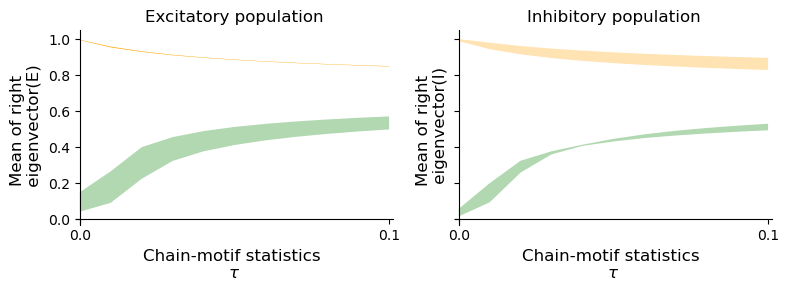

In [54]:
### plot the mean of the left and right eigenvectors
dtau = tau_series[1]-tau_series[0]
tau_max = tau_series[-1]
fig,ax=plt.subplots(1,2,figsize=(8,3),sharex=True,sharey=True)
ax[0].fill_between(tau_series,np.nanmean(mean_reigvec_num_series[:,:,0,0],axis=0)-np.nanstd(mean_reigvec_num_series[:,:,0,0],axis=0),np.nanmean(mean_reigvec_num_series[:,:,0,0],axis=0)+np.nanstd(mean_reigvec_num_series[:,:,0,0],axis=0),facecolor='orange',alpha=1.0)
## second rank
ax[0].fill_between(tau_series,np.nanmean(mean_reigvec_num_series[:,:,1,0],axis=0)-np.nanstd(mean_reigvec_num_series[:,:,1,0],axis=0),np.nanmean(mean_reigvec_num_series[:,:,1,0],axis=0)+np.nanstd(mean_reigvec_num_series[:,:,1,0],axis=0),facecolor='green',alpha=0.3)

### excitatory population
ax[0].set_title('Excitatory population',fontsize=12)
## move the x-axis to  the cecnter
ax[0].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[0].spines['top'].set_color('none')
ax[0].spines['right'].set_color('none')
ax[0].spines['left'].set_position(('data',0))
ax[0].set_xticks([0,0.1,0.2])
ax[0].set_xlim(0,tau_max+0.02/8)
# ax[0].set_ylim(-0.01,0.04)
# ax[0].set_yticks([0,0.04])
# ax[0].set_ylim(-0.,1.5)
# ax[0].set_yticks([0,1.5])
ax[0].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[0].set_ylabel('Mean of right \n eigenvector(E)',fontsize=12)

### start the inhibitory population
ax[1].fill_between(tau_series,np.nanmean(mean_reigvec_num_series[:,:,0,1],axis=0)-np.nanstd(mean_reigvec_num_series[:,:,0,1],axis=0),np.nanmean(mean_reigvec_num_series[:,:,0,1],axis=0)+np.nanstd(mean_reigvec_num_series[:,:,0,1],axis=0),facecolor='orange',alpha=0.3)
## second rank
ax[1].fill_between(tau_series,np.nanmean(mean_reigvec_num_series[:,:,1,1],axis=0)-np.nanstd(mean_reigvec_num_series[:,:,1,1],axis=0),np.nanmean(mean_reigvec_num_series[:,:,1,1],axis=0)+np.nanstd(mean_reigvec_num_series[:,:,1,1],axis=0),facecolor='green',alpha=0.3)

### move the x-axis to  the cecnter
ax[1].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[1].spines['top'].set_color('none')
ax[1].spines['right'].set_color('none')
ax[1].spines['left'].set_position(('data',0))
ax[1].set_title('Inhibitory population',fontsize=12)
ax[1].set_xticks([0,0.1,0.2])
ax[1].set_xlim(0-dtau/8.0,tau_max+dtau/8)
# # ax[1].set_ylim(-0.01,0.04)
# ax[1].set_ylim(-0.1,1.5)
ax[1].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[1].set_ylabel('Mean of right \n eigenvector(I)',fontsize=12)
fig.tight_layout()
plt.show()

Fig5(cd)

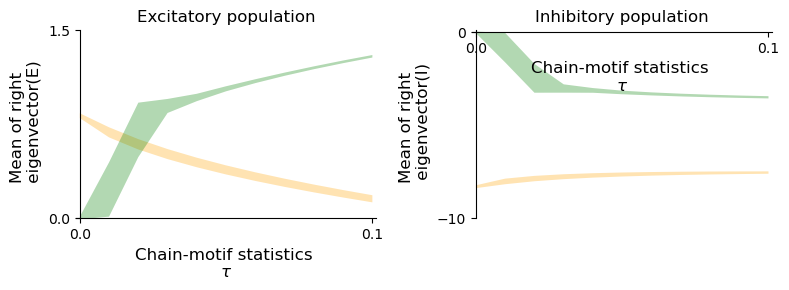

In [56]:
### plot the mean of the left and right eigenvectors
dtau = tau_series[1]-tau_series[0]
tau_max = tau_series[-1]
fig,ax=plt.subplots(1,2,figsize=(8,3),sharex=True)
ax[0].fill_between(tau_series,np.nanmean(mean_leigvec_num_series[:,:,0,0],axis=0)-np.nanstd(mean_leigvec_num_series[:,:,0,0],axis=0),np.nanmean(mean_leigvec_num_series[:,:,0,0],axis=0)+np.nanstd(mean_leigvec_num_series[:,:,0,0],axis=0),facecolor='orange',alpha=0.3)
## second rank
ax[0].fill_between(tau_series,np.nanmean(mean_leigvec_num_series[:,:,1,0],axis=0)-np.nanstd(mean_leigvec_num_series[:,:,1,0],axis=0),np.nanmean(mean_leigvec_num_series[:,:,1,0],axis=0)+np.nanstd(mean_leigvec_num_series[:,:,1,0],axis=0),facecolor='green',alpha=0.3)

### excitatory population
ax[0].set_title('Excitatory population',fontsize=12)
## move the x-axis to  the cecnter
ax[0].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[0].spines['top'].set_color('none')
ax[0].spines['right'].set_color('none')
ax[0].spines['left'].set_position(('data',0))
ax[0].set_xticks([0,0.1,0.2])
ax[0].set_xlim(0,tau_max+0.02/8)
ax[0].set_ylim(-0.01,0.04)
# ax[0].set_yticks([0,0.04])
ax[0].set_ylim(-0.,1.5)
ax[0].set_yticks([0,1.5])
ax[0].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[0].set_ylabel('Mean of right \n eigenvector(E)',fontsize=12)

### start the inhibitory population
ax[1].fill_between(tau_series,np.nanmean(mean_leigvec_num_series[:,:,0,1],axis=0)-np.nanstd(mean_leigvec_num_series[:,:,0,1],axis=0),np.nanmean(mean_leigvec_num_series[:,:,0,1],axis=0)+np.nanstd(mean_leigvec_num_series[:,:,0,1],axis=0),facecolor='orange',alpha=0.3)
## second rank
ax[1].fill_between(tau_series,np.nanmean(mean_leigvec_num_series[:,:,1,1],axis=0)-np.nanstd(mean_leigvec_num_series[:,:,1,1],axis=0),np.nanmean(mean_leigvec_num_series[:,:,1,1],axis=0)+np.nanstd(mean_leigvec_num_series[:,:,1,1],axis=0),facecolor='green',alpha=0.3)

### move the x-axis to  the cecnter
ax[1].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[1].spines['top'].set_color('none')
ax[1].spines['right'].set_color('none')
ax[1].spines['left'].set_position(('data',0))
ax[1].set_title('Inhibitory population',fontsize=12)
ax[1].set_xticks([0,0.1,0.2])
ax[1].set_xlim(0-dtau/8.0,tau_max+dtau/8)
# ax[1].set_ylim(-0.1,0.2)
ax[1].set_ylim(-10,0.1)
ax[1].set_yticks([-10,0])
ax[1].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[1].set_ylabel('Mean of Left \n eigenvector(I)',fontsize=12)
fig.tight_layout()
plt.show()

In [57]:
## recaling the eigenvectors -- back
mean_reigvec_num_series /= np.sqrt(N)
mean_leigvec_num_series /= np.sqrt(N)
mean_leig0vec_num_series /= np.sqrt(N)

In [ ]:
### compute the theoretical eigenvalue outliers and the spectral radius
### recording 
gaverage     = g_max
eigvchn_theo = np.zeros((ntau,2))
radius_theo_map  = np.zeros(ntau)
        
for it, tau in enumerate(tau_series):
    ### solve the equations
    sigmae, sigmai = gaverage, gaverage
    
    x0 = np.array([0.01,0.01])
    # x0 = np.array([0.1,0.1])
    sol = fsolve(compute_AdjacencyParams,x0,args=(JE,JI,sigmae,sigmai,Nparams))
    ce,ci = sol[0],sol[1]
    J = JE/NE/ce
    g = JI/NI/ci/J
    print('ce,ci:',ce,ci)
    print('J,g:',J,g)
    ### generate the corresponding sparse matrix
    ### mean connectivity 
    je, ji = J, g*J
    hat_sigmae, hat_sigmai = np.sqrt(ce*(1-ce)),np.sqrt(ci*(1-ci))
    sigmae, sigmai = np.sqrt(je**2*ce*(1-ce)*N), np.sqrt(ji**2*ci*(1-ci)*N) 
    ### generate tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec
    tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec = np.zeros(2),np.zeros((2,2)),np.zeros((2,2)),np.zeros((2,2))
    ### YS: alltaus do not have E-I polarity
    tau_div_vec = np.array([tau,tau])
    tau_con_vec = np.array([[tau,tau],[tau,tau]])
    tau_rec_vec = np.array([[2*tau,-2*tau],[-2*tau,2*tau]])
    # tau_rec_vec = np.array([[2*tau,2*tau],[2*tau,2*tau]])
    tau_chn_vec = np.array([[tau,-tau],[-tau,tau]])
    # gamma = 1.0 ## NI/NE
    sigma = np.sqrt(sigmae**2/(1+gamma)+sigmai**2*gamma/(1+gamma))
    ### compute the radius 
    # compute a single number for multiple populations
    tau_div_num = hat_sigmae**2*tau_div_vec[0]+gamma*g**2*hat_sigmai**2*tau_div_vec[1]
    tau_div_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_div = tau_div_num/tau_div_den

    tau_con_num = hat_sigmae**2*tau_con_vec[0,0]+gamma*g**2*hat_sigmai**2*tau_con_vec[1,1]
    tau_con_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_con  = tau_con_num/tau_con_den

    tau_rec_num = hat_sigmae**2*tau_rec_vec[0,0] - (1+gamma)*g*hat_sigmae*hat_sigmai*tau_rec_vec[0,1]+gamma*g**2*hat_sigmai**2*tau_rec_vec[1,1]
    tau_rec_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_rec = tau_rec_num/tau_rec_den/2.0 

    tau_chn_num = hat_sigmae**2*tau_chn_vec[0,0] - 0.5*(1+gamma)*g*hat_sigmae*hat_sigmai*(tau_chn_vec[0,1]+tau_chn_vec[1,0])+gamma*g**2*hat_sigmai**2*tau_chn_vec[1,1]
    tau_chn_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_chn = tau_chn_num/tau_chn_den/2.0

    radius_theo = (1.0-tau_con-tau_div+tau_rec-2*tau_chn)/np.sqrt(1-tau_con-tau_div)*sigma
    
    radius_theo_map[it] = radius_theo
    print(radius_theo,gamma,hat_sigmae**2)
            
    ### then the theoretical solutions for the eigenvalue outliers
    ### theoretical solutions
    x0 = np.mean(eigvchn_series[:,it,:2].real,axis=0)
    N = int(NE+NI)
    for ir in range(2):
        t1 = fsolve(equations,x0[ir].real,args=[gaverage,tau,(JE-JI),N])
        eigvchn_theo[it,ir] = t1

In [59]:
### compute low-rank theoretical
contribution_fr = np.zeros((trials,ntau,2,2))
firing_rate_lwfr = np.zeros((trials,ntau,2))
for ktrial in range(trials):
    for it in range(ntau):
            for ir in range(2):
                contribution_fr[ktrial,it,ir,0] = np.squeeze(((mean_leigvec_num_series[ktrial,it,ir,0])*Inp[0]*NE+(mean_leigvec_num_series[ktrial,it,ir,1])*Inp[0]*NI)/(1-eigvchn_series[ktrial,it,ir].real)*(mean_reigvec_num_series[ktrial,it,ir,0]))
                contribution_fr[ktrial,it,ir,1] = np.squeeze(((mean_leigvec_num_series[ktrial,it,ir,0])*Inp[0]*NE+(mean_leigvec_num_series[ktrial,it,ir,1])*Inp[0]*NI)/(1-eigvchn_series[ktrial,it,ir].real)*(mean_reigvec_num_series[ktrial,it,ir,1]))
    firing_rate_lwfr[ktrial,:,:] = np.ones((ntau,2))*Inp[0]
    firing_rate_lwfr[ktrial,:,:] +=np.sum(contribution_fr[ktrial,:,:,:].copy(),axis=1)


In [60]:
### compute the population mean and variance
### compute the population mean and variance
firing_rate0_mean,firing_rate0_var = np.zeros(2),np.zeros(2)
firing_rate0_mean[0],firing_rate0_mean[1] = np.mean(firing_rate0[:NE]),np.mean(firing_rate0[NE:])
firing_rate0_var[0],firing_rate0_var[1]   = np.var(firing_rate0[:NE]),np.var(firing_rate0[NE:])

# ntau = 6
firing_rateeq_mean,firing_rateeq_var = np.zeros((trials,ntau,2)),np.zeros((trials,ntau,2))
firing_rateeq_mean[:,:,0],firing_rateeq_mean[:,:,1] = np.mean(firing_rateeq[:,:,:NE],axis=2),np.mean(firing_rateeq[:,:,NE:],axis=2)
firing_rateeq_var[:,:,0],firing_rateeq_var[:,:,1]   = np.var(firing_rateeq[:,:,:NE],axis=2),np.var(firing_rateeq[:,:,NE:],axis=2)

frate_real = firing_rateeq_mean[:,-1,0].copy()
### sorting eigvchn_real 
idx = np.argsort(frate_real)
idx_eff = idx[3:-3]
print('effective trials:',idx_eff,len(idx_eff))

effective trials: [ 3 27  5 33  7  6 18 15 24  8  4 20 16 26  9 32 14 35 22  1 17 31 29  0
  2 12 10 11 21 30] 30


##### Network dynamics (Figure 6) 

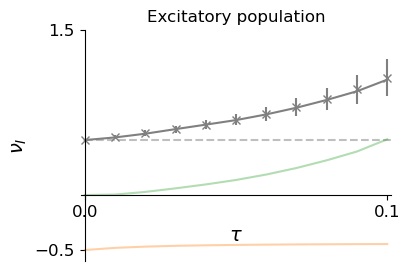

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

idxpop = 0 ### excitatory population 
fig, ax = plt.subplots(figsize=(4,3))

std_lwfr = np.nanstd(firing_rateeq_mean[:,:,0]/Inp[0],axis=0)
ax.errorbar(tau_series,np.nanmean(firing_rateeq_mean[:,:,idxpop]/Inp[0],axis=0),yerr=std_lwfr,fmt='x',color='gray',ecolor='gray',alpha=1,ls='',elinewidth=1.5)
std_lwfr = np.nanstd(firing_rate_lwfr[:,:,0]/Inp[0],axis=0)
ax.plot(tau_series,np.nanmean(firing_rate_lwfr[:,:,0].real,axis=0)/Inp[0],color='gray',alpha=1,lw=1.5)

### set y-axis    

# ax.set_title('Side-by-Side Boxplots of Data1 and Data2 with Face Color Alpha')

### right and top axes visible = 'false'
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim(-.6,1.5)
ax.set_yticks([-.5,1.5])

ax.plot(np.arange(ntau), firing_rate0_mean[0]*np.ones((ntau,))/Inp[0],linestyle='--',color='gray',linewidth=1.5,alpha=0.5)



### contribution_fr
### Plot the contributions from individual ranks
htau = tau_series[1]-tau_series[0]
### start with the excitatory neuron population
### contribution from the first rank-1 component Excitatory population
ax.plot(tau_series,np.nanmean(contribution_fr[:,:,0,0].real,axis=0)/Inp[0],color='tab:orange',alpha=0.36,lw=1.5)
ax.plot(tau_series, np.nanmean(contribution_fr[:,:,1,0].real,axis=0)/Inp[0],color='tab:green',alpha=0.36,lw=1.5)

### design the axes
ax.set_xlim(tau_series[0]-htau/8.0,tau_series[-1]+htau/8.0)
ax.set_xticks([tau_series[0],tau_series[-1]])
### move the axes to the center
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'$\tau$',fontsize=14)
ax.set_ylabel(r'$\nu_{I}$',fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('Excitatory population',fontsize=12)
plt.show()

#### Save data

In [ ]:
def list_to_dict(lst, string):
    """
    Transform a list of variables into a dictionary.
    Parameters
    ----------
    lst : list
        list with all variables.
    string : str
        string containing the names, separated by commas.
    Returns
    -------
    d : dict
        dictionary with items in which the keys and the values are specified
        in string and lst values respectively.
    """
    string = string[0]
    string = string.replace(']', '')
    string = string.replace('[', '')
    string = string.replace('\\', '')
    string = string.replace(' ', '')
    string = string.replace('\t', '')
    string = string.replace('\n', '')
    string = string.split(',')
    d = {s: v for s, v in zip(string, lst)}
    return d

In [ ]:
# params = {'gaverage':gaverage,
#           'gamma':gamma,
#           'JE':JE,
#           'JI':JI,
#           'NE':NE,
#           'NI':NI,
#           'tau_series':tau_series,
#           }
# lst = [eigvchn_series, eigrvec_series, eiglvec_series,
#        eigrvec_series_rec, eiglvec_series_rec,
#         eiglvec0_series, norml0_series, params,
#         firing_rateeq,firing_rate0]
# stg = ["eigvchn_series, eigrvec_series, eiglvec_series,"
#        "eigrvec_series_rec, eiglvec_series_rec,"
#         "eiglvec0_series, norml0_series, params,"
#         "firing_rateeq,firing_rate0"]
# data = list_to_dict(lst=lst, string=stg)
# data_name = "---save the data---"
# # np.savez(data_name, **data)

In [ ]:
data_name = "---load the data---"
data = np.load(data_name,allow_pickle=True)
eigvchn_series = data['eigvchn_series']
eigrvec_series = data['eigrvec_series']
eiglvec_series = data['eiglvec_series']
eiglvec0_series = data['eiglvec0_series']
norml0_series = data['norml0_series']
params = data['params']
intg_ov_series = data['intg_ov_series']
first_perturb_ov = data['first_perturb_ov']
first_perturb_ovP = data['first_perturb_ovP']
intg_mean_series = data['intg_mean_series']
intg_std_series = data['intg_std_series']
intg_std_num_series = data['intg_std_num_series']
intg_crossov_series = data['intg_crossov_series']
intg_crossovPop_series = data['intg_crossovPop_series']
firing_rateeq = data['firing_rateeq']
params